[![General Assembly Logo](https://camo.githubusercontent.com/1a91b05b8f4d44b5bbfb83abac2b0996d8e26c92/687474703a2f2f692e696d6775722e636f6d2f6b6538555354712e706e67)](https://generalassemb.ly/education/web-development-immersive)
![Misk Logo](https://i.ibb.co/KmXhJbm/Webp-net-resizeimage-1.png)

# Introduction to Natural Language Processing Lab

In this lab we will further explore sklearn and NLTK's capabilities for processing text. We will use the 20 Newsgroup dataset, which is provided by sklearn.

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Getting the Sklearn Dataset
from sklearn.datasets import fetch_20newsgroups

### 1. Use the `fetch_20newsgroups` function to download a training and testing set.

Look up the [function documentation](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html) for how to grab the data.

You should pull these categories:
- `alt.atheism`
- `talk.religion.misc`
- `comp.graphics`
- `sci.space`

Also remove the headers, footers, and quotes using the `remove` keyword argument of the function.

In [141]:
# Extracting Information from the Data's Dictionary format 
# Categories of emails we want
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Setting training data
data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=('headers', 'footers', 'quotes'))
# Setting testing data
data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=('headers', 'footers', 'quotes'))

### 2. Data inspection

We have downloaded a few newsgroup categories and removed headers, footers and quotes.

Because this is an sklearn dataset, it comes with pre-split train and test sets (note we were able to call 'train' and 'test' in subset).

Let's inspect them.

1. What data type is `data_train`?
- What does `data_train` contain? 
- How many data points does `data_train` contain?
- How many data points of each category does `data_train` contain?
- Inspect the first data point, what does it look like?

In [550]:
# A:
print('The type of data datatrain ',type(data_train))

The type of data datatrain  <class 'sklearn.utils.Bunch'>


In [354]:
# Define dataframes of datatrain and datatest
df_data_train = pd.DataFrame({'news':data_train.data,'categ_name':data_train.target})
df_data_test = pd.DataFrame({'news':data_test.data,'categ_name':data_test.target})

# Map the categories name to each news and replace the categories index with its name
df_data_train.categ_name = df_data_train.categ_name.map(lambda x: data_train.target_names[x])
df_data_test.categ_name = df_data_test.categ_name.map(lambda x: data_test.target_names[x])

In [56]:
print('The number of data points is ' ,len(data_train.data))

The number of data points is  2034


In [361]:
# Show the number of news per category
df_data_train.categ_name.value_counts()

sci.space             593
comp.graphics         584
alt.atheism           480
talk.religion.misc    377
Name: categ_name, dtype: int64

In [362]:
# Show the first news
df_data_train.news.iloc[0]

"Hi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych"

### 3. Bag of Words model

Let's train a model using a simple count vectorizer.

1. Initialize a standard CountVectorizer and fit the training data.
- How big is the feature dictionary?
- Repeat eliminating English stop words.
- Is the dictionary smaller?
- Transform the training data using the trained vectorizer.
- What are the 20 words that are most common in the whole corpus?
- What are the 20 most common words in each of the 4 classes?
- Evaluate the performance of a Logistic Regression on the features extracted by the CountVectorizer.
    - You will have to transform the test_set, too. Be careful to use the trained vectorizer, without re-fitting it.
    - Create a confusion matrix.

**BONUS:**
- Try a couple of modifications:
    - restrict max_features
    - change max_df and min_df
    - for each of the above print a confusion matrix and investigate what gets mixed

In [556]:
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate CountVectorizer
cv = CountVectorizer()

# Fit the news with CountVectorizer
bow = cv.fit(df_data_train.news)

# Use vocabulary_ attribute to show number words in feature dictionary
print('The number of words in dictionary is ',len(bow.vocabulary_))

The number of words in dictionary is  26879


In [371]:
stop_words = stopwords.words('english') # defining stop_words
stop_words.remove('not')                # removing 'not' since the dataset contains negative news

lemmatizer = WordNetLemmatizer()

def data_preprocessing(review):
    # data cleaning
    review = re.sub(re.compile('<.*?>'), '', review)  # removing html tags
    review = re.sub('[^A-Za-z0-9]+', ' ', review)               # taking only words

    # lowercase
    review = review.lower()

    # tokenization
    tokens = word_tokenize(review)

    # stop words removal
    review = [word for word in tokens if word not in stop_words]

    # lemmatization
    review = [lemmatizer.lemmatize(word) for word in review]

    # join words in preprocessed review
    review = ' '.join(review)

    return review

In [372]:
# Use data_preprocessing function to remove the stop words
df_data_train['preprocessed_news'] = df_data_train['news'].apply(lambda news: data_preprocessing(news))
df_data_test['preprocessed_news'] = df_data_test['news'].apply(lambda news: data_preprocessing(news))

In [559]:
# Fit the cleaned news with CountVectorizer
bow_cleaned = cv.fit(df_data_train.preprocessed_news)

# Use vocabulary_ attribute to show number cleaned words in feature dictionary
print(f'The number of words after preprocessing in dictionary is {len(bow_cleaned.vocabulary_)}\nIt is smaller than the pervious one')

The number of words after preprocessing in dictionary is 23631
It is smaller than the pervious one


In [374]:
bow_t = bow_cleaned.transform(df_data_train.preprocessed_news)

# Define dataframe that contains the frequency of words in each news
count_vect_df = pd.DataFrame(bow_t.todense(), columns=bow_cleaned.get_feature_names())

In [476]:
# Define dataframe that contains the sum of words frequency 
sum_df = pd.DataFrame(np.sum(bow_t.todense(),axis=0), columns=cv.get_feature_names())

# Sort by the frequency of words of first 20 common words
sum_df.sort_values(by=0, ascending=False, axis=1).iloc[:,:20]

,not,one,would,space,image,god,people,also,like,time,know,system,think,get,file,say,program,see,thing,could
0,2753,1241,1130,1064,844,802,796,724,689,664,644,643,620,558,548,544,515,503,492,484


In [377]:
# Define dataframe that contains the frequency of words with their category
df_data_train_1 = pd.concat([count_vect_df,df_data_train.categ_name],axis=1)

In [562]:
# Filter words that belongs the talk.religion.misc category
df_data_train_categ1 = df_data_train_1[df_data_train_1.categ_name == 'talk.religion.misc'].drop(columns='categ_name')

# Define dataframe that contains the sum of top 20 words frequency and sotred
most_frequent1 = df_data_train_categ1.sum(axis=0).sort_values(ascending = False)[:20]

print('The top 20 common words in talk.religion.misc category\n')
pd.DataFrame(most_frequent1).T

The top 20 common words in talk.religion.misc category



,not,god,one,people,jesus,would,christian,say,bible,think,know,see,even,may,good,like,life,word,way,also
0,828,337,300,268,256,247,242,211,163,163,160,148,140,139,134,134,133,133,132,129


In [551]:
# Filter words that belongs the alt.atheism category
df_data_train_categ2 = df_data_train_1[df_data_train_1.categ_name == 'alt.atheism'].drop(columns='categ_name')

# Define dataframe that contains the sum of top 20 words frequency and sotred
most_frequent2 = df_data_train_categ2.sum(axis=0).sort_values(ascending = False)[:20]
pd.DataFrame(most_frequent2).T

,not,god,one,people,would,atheist,think,say,atheism,religion,argument,thing,many,make,know,believe,like,time,belief,even
0,1057,450,441,332,294,262,228,218,200,200,195,179,176,174,167,164,163,159,158,156


In [564]:
# Filter words that belongs the sci.space category
df_data_train_categ3 = df_data_train_1[df_data_train_1.categ_name == 'sci.space'].drop(columns='categ_name')

# Define dataframe that contains the sum of top 20 words frequency and sotred
most_frequent3 = df_data_train_categ3.sum(axis=0).sort_values(ascending = False)[:20]

print('The top 20 common words in sci.space category\n')
pd.DataFrame(most_frequent3).T

The top 20 common words in sci.space category



,space,not,nasa,would,launch,one,satellite,year,system,time,also,orbit,mission,like,earth,data,get,shuttle,program,first
0,991,484,373,368,314,291,287,277,266,243,236,229,225,225,223,216,209,196,195,185


In [565]:
# Filter words that belongs the comp.graphics category
df_data_train_categ4 = df_data_train_1[df_data_train_1.categ_name == 'comp.graphics'].drop(columns='categ_name')

# Define dataframe that contains the sum of top 20 words frequency and sotred
most_frequent4 = df_data_train_categ4.sum(axis=0).sort_values(ascending = False)[:20]

print('The top 20 common words in comp.graphics category\n')
pd.DataFrame(most_frequent4).T

The top 20 common words in comp.graphics category



,image,file,graphic,not,program,jpeg,format,edu,also,color,use,system,would,data,software,one,ftp,available,bit,know
0,718,482,429,384,296,265,258,251,232,232,225,223,221,220,214,209,189,185,184,182


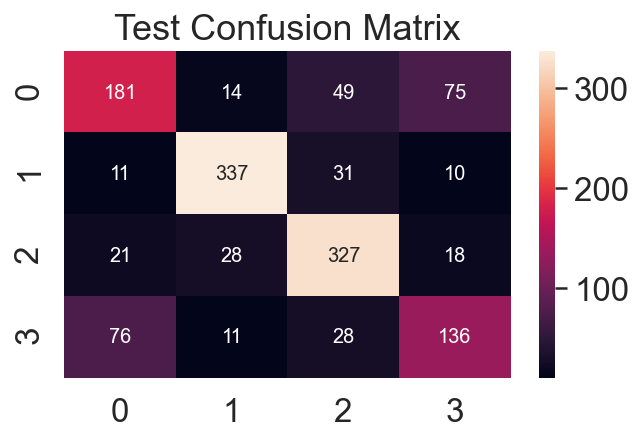

Train Accuracy Score of BOW: 0.971976401179941
Test Accuracy Score of BOW: 0.7250554323725056


In [478]:
# Instantiate CountVectorizer with minimum frequency 20
vect = CountVectorizer(min_df=10)

# Vectorized the data
X_train_news = vect.fit_transform(df_data_train.preprocessed_news)
X_test_news = vect.transform(df_data_test.preprocessed_news)

# Define y for train and test
y_train = df_data_train.categ_name.values
y_test = df_data_test.categ_name.values

# Instantiate Logistic Regression Model
clf = LogisticRegression()

# Fit train data into model
clf.fit(X_train_news, y_train)

# Predict y train and test
y_pred_train = clf.predict(X_train_news)
y_pred_test = clf.predict(X_test_news)

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

print(f"Train Accuracy Score of BOW: {accuracy_score(y_train,y_pred_train)}")
print(f"Test Accuracy Score of BOW: {accuracy_score(y_test,y_pred_test)}")

### 4. TF-IDF

Let's see if TF-IDF improves the accuracy.

1. Initialize a TF-IDF Vectorizer and repeat the test with no restriction on the number of features.
- Does the score improve with respect to the count vectorizer? 
- Print out the number of features for this model.




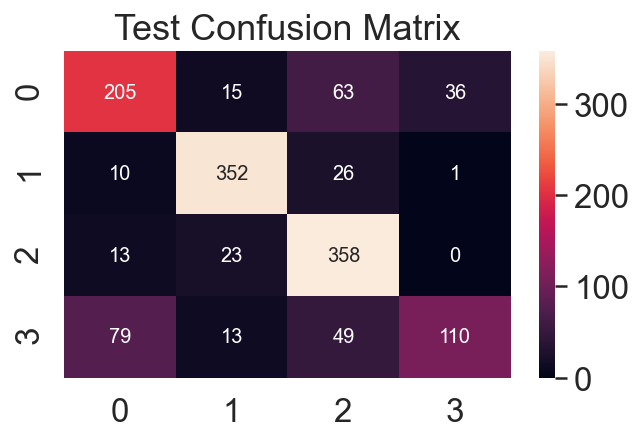

Train Accuracy Score of TF-IDF: 0.9552605703048181
Test Accuracy Score of TF-IDF: 0.7575757575757576

The number of feature After using TF-IDF: 23631


In [479]:
# A:
# Instantiate TfidfVectorizer with minimum frequency 20
vect = TfidfVectorizer()

# Vectorized the data
X_train_news_Tfidf = vect.fit_transform(df_data_train.preprocessed_news)
X_test_news_Tfidf = vect.transform(df_data_test.preprocessed_news)

# Instantiate Logistic Regression Model
clf = LogisticRegression()

# Fit train data into model
clf.fit(X_train_news_Tfidf, y_train)


# Predict y train and test
y_pred_train = clf.predict(X_train_news_Tfidf)
y_pred_test = clf.predict(X_test_news_Tfidf)

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

print(f"Train Accuracy Score of TF-IDF: {accuracy_score(y_train,y_pred_train)}")
print(f"Test Accuracy Score of TF-IDF: {accuracy_score(y_test,y_pred_test)}")
print(f"\nThe number of feature After using TF-IDF: {X_train_news_Tfidf.shape[1]}")

### 5. Classifier comparison

Of all the vectorizers tested above, choose one that has a reasonable performance with a manageable number of features and compare the performance of these models:

- KNN
- Logistic Regression
- Decision Trees
- Support Vector Machine
- Random Forest

In order to speed up the calculation it's better to vectorize the data only once and then compare the models.

#### 5.a KNN

In [552]:
# Instantiate pipeline object
knn_pipe1 = Pipeline([
    ('vect1', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

# Define dictionary of hyperparameters
pipe_params = {
    'vect1__min_df': np.linspace(10,50,num=5,dtype=int).tolist()+[None],
    'vect1__max_df': np.linspace(50,300,num=6,dtype=int).tolist()+[None],
    'knn__n_neighbors' : np.linspace(1,10,num=10,dtype=int)
}

# Instantiate our GridSearchCV object.
pipe_gridsearch = GridSearchCV(knn_pipe1, # What is the model we want to fit?
                                 pipe_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=1,
                                n_jobs=4)

# Fit the GridSearchCV object to the train data
pipe_gridsearch.fit(df_data_train.preprocessed_news,y_train)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   34.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   57.8s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 2100 out of 2100 | elapsed:  2.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect1', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=4,
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'vect1__max_df': [50, 100, 150, 200, 250, 300, None],
                         'vect1__min_df': [10, 20, 30, 40, 50, None]},
             verbose=1)

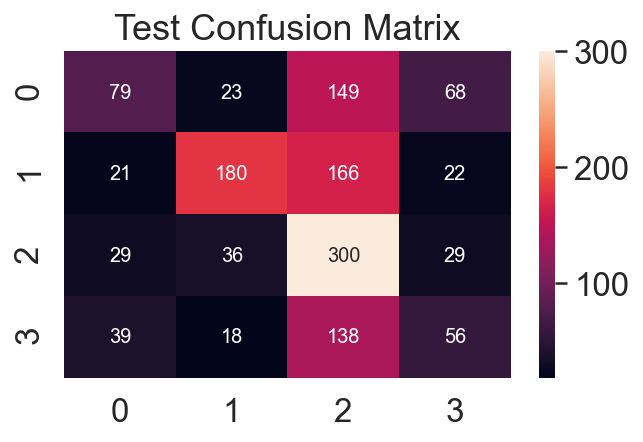

Train Accuracy Score of KNN: 0.9385447394296952
Test Accuracy Score of KNN: 0.45454545454545453


In [525]:
# Predict y for train and test data
y_pred_train = pipe_gridsearch.predict(df_data_train.preprocessed_news)
y_pred_test = pipe_gridsearch.predict(df_data_test.preprocessed_news)

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

# Define the dictionary of best test score
best_score = {}

print(f"Train Accuracy Score of KNN: {accuracy_score(y_train,y_pred_train)}")
print(f"Test Accuracy Score of KNN: {accuracy_score(y_test,y_pred_test)}")

# Add the test score to dictionary 
best_score['Knn'] = accuracy_score(y_test,y_pred_test)

#### 5.b Logistic Regression

In [553]:
# Instantiate pipeline object
lg_pipe1 = Pipeline([
    ('vect1', TfidfVectorizer()),
    ('logreg1', LogisticRegression())
])

# Define dictionary of hyperparameters
pipe_params = {
    'vect1__min_df': np.linspace(10,50,num=5,dtype=int).tolist()+[None],
    'vect1__max_df': np.linspace(50,300,num=6,dtype=int).tolist()+[None],
    'logreg1__penalty' : ['l1','l2']
}

# Instantiate our GridSearchCV object.
pipe_gridsearch = GridSearchCV(lg_pipe1, # What is the model we want to fit?
                                 pipe_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=1,
                                n_jobs=4)

# Fit the GridSearchCV object to the train data
pipe_gridsearch.fit(df_data_train.preprocessed_news,y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done 420 out of 420 | elapsed:   29.2s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect1', TfidfVectorizer()),
                                       ('logreg1', LogisticRegression())]),
             n_jobs=4,
             param_grid={'logreg1__penalty': ['l1', 'l2'],
                         'vect1__max_df': [50, 100, 150, 200, 250, 300, None],
                         'vect1__min_df': [10, 20, 30, 40, 50, None]},
             verbose=1)

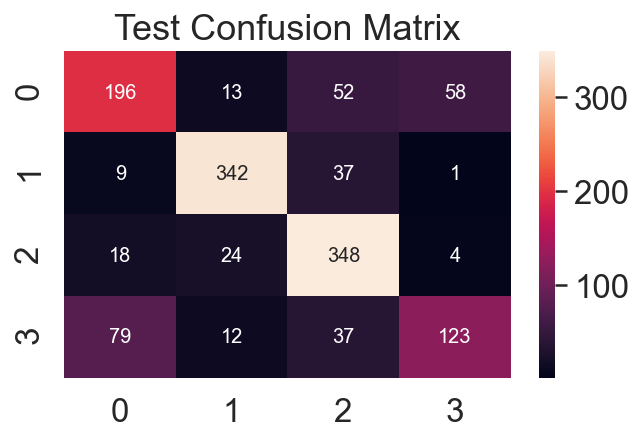

Train Accuracy Score of Logistic Regression: 0.9454277286135693
Test Accuracy Score of Logistic Regression: 0.745750184774575


In [527]:
# Predict y for train and test data
y_pred_train = pipe_gridsearch.predict(df_data_train.preprocessed_news)
y_pred_test = pipe_gridsearch.predict(df_data_test.preprocessed_news)


cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

print(f"Train Accuracy Score of Logistic Regression: {accuracy_score(y_train,y_pred_train)}")
print(f"Test Accuracy Score of Logistic Regression: {accuracy_score(y_test,y_pred_test)}")

# Add the test score to dictionary 
best_score['Logistic Regression'] = accuracy_score(y_test,y_pred_test)

#### 5.c Decision Tree

In [554]:
# Instantiate pipeline object
dt_pipe1 = Pipeline([
    ('vect1', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier())
])

# Define dictionary of hyperparameters
pipe_params = {
    'vect1__min_df': np.linspace(10,50,num=5,dtype=int).tolist()+[None],
    'vect1__max_df': np.linspace(50,300,num=6,dtype=int).tolist()+[None],
    'dt__criterion' : ['gini', 'entropy'],
}

# Instantiate our GridSearchCV object.
pipe_gridsearch = GridSearchCV(dt_pipe1, # What is the model we want to fit?
                                 pipe_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=1,
                                n_jobs=4)

# Fit the GridSearchCV object to the train data
pipe_gridsearch.fit(df_data_train.preprocessed_news,y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.7s
[Parallel(n_jobs=4)]: Done 420 out of 420 | elapsed:   35.9s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect1', TfidfVectorizer()),
                                       ('dt', DecisionTreeClassifier())]),
             n_jobs=4,
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'vect1__max_df': [50, 100, 150, 200, 250, 300, None],
                         'vect1__min_df': [10, 20, 30, 40, 50, None]},
             verbose=1)

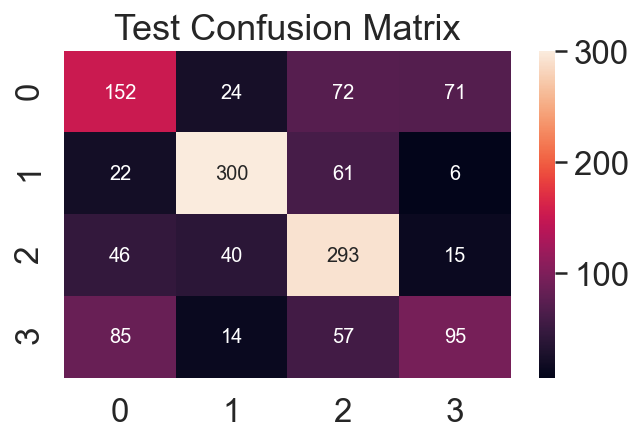

Train Accuracy Score of Decision Tree: 0.9749262536873157
Test Accuracy Score of Decision Tree: 0.6208425720620843


In [539]:
# Predict y for train and test data
y_pred_train = pipe_gridsearch.predict(df_data_train.preprocessed_news)
y_pred_test = pipe_gridsearch.predict(df_data_test.preprocessed_news)

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

print(f"Train Accuracy Score of Decision Tree: {accuracy_score(y_train,y_pred_train)}")
print(f"Test Accuracy Score of Decision Tree: {accuracy_score(y_test,y_pred_test)}")

# Add the test score to dictionary 
best_score['Decision Tree'] = accuracy_score(y_test,y_pred_test)

#### 5.d SVM

In [555]:
# Instantiate pipeline object
svc_pipe1 = Pipeline([
    ('vect1', TfidfVectorizer()),
    ('svc', SVC())
])

# Define dictionary of hyperparameters
pipe_params = {
    'vect1__min_df': np.linspace(10,50,num=5,dtype=int),
    'vect1__max_df': np.linspace(50,300,num=6,dtype=int),
    'svc__C' : np.linspace(0.1,1,num=10),
}

# Instantiate our GridSearchCV object.
pipe_gridsearch = GridSearchCV(svc_pipe1, # What is the model we want to fit?
                                 pipe_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=1,
                                n_jobs=4)

# Fit the GridSearchCV object to the train data
pipe_gridsearch.fit(df_data_train.preprocessed_news,y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:  6.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect1', TfidfVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=4,
             param_grid={'svc__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'vect1__max_df': array([ 50, 100, 150, 200, 250, 300]),
                         'vect1__min_df': array([10, 20, 30, 40, 50])},
             verbose=1)

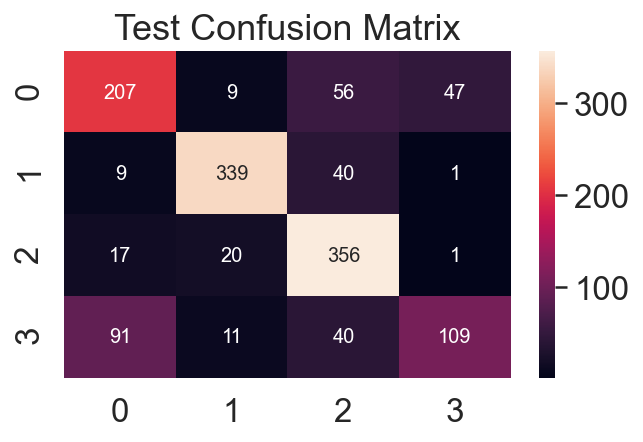

Train Accuracy Score of SVM: 0.9729596853490659
Test Accuracy Score of SVM: 0.7472283813747228


In [531]:
# Predict y for train and test data
y_pred_train = pipe_gridsearch.predict(df_data_train.preprocessed_news)
y_pred_test = pipe_gridsearch.predict(df_data_test.preprocessed_news)

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

print(f"Train Accuracy Score of SVM: {accuracy_score(y_train,y_pred_train)}")
print(f"Test Accuracy Score of SVM: {accuracy_score(y_test,y_pred_test)}")

# Add the test score to dictionary 
best_score['SVM'] = accuracy_score(y_test,y_pred_test)

#### 5.e Random Forest

In [532]:
# Instantiate pipeline object
rf_pipe1 = Pipeline([
    ('vect1', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# Define dictionary of hyperparameters
pipe_params = {
    'vect1__max_df': np.linspace(50,700,num=8,dtype=int),
}

# Instantiate our GridSearchCV object.
pipe_gridsearch = GridSearchCV(rf_pipe1, # What is the model we want to fit?
                                 pipe_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=1,
                                n_jobs=4)

# Fit the GridSearchCV object to the train data
pipe_gridsearch.fit(df_data_train.preprocessed_news,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   24.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect1', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=4,
             param_grid={'vect1__max_df': array([ 50, 142, 235, 328, 421, 514, 607, 700])},
             verbose=1)

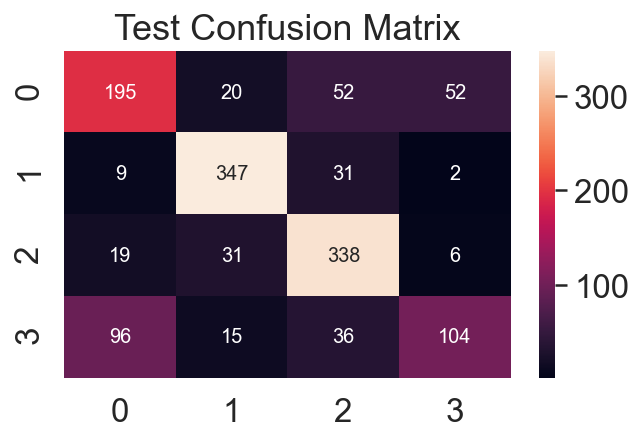

Train Accuracy Score of Random Forest: 0.9783677482792527
Test Accuracy Score of Random Forest: 0.7272727272727273


In [533]:
# Predict y for train and test data
y_pred_train = pipe_gridsearch.predict(df_data_train.preprocessed_news)
y_pred_test = pipe_gridsearch.predict(df_data_test.preprocessed_news)

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

print(f"Train Accuracy Score of Random Forest: {accuracy_score(y_train,y_pred_train)}")
print(f"Test Accuracy Score of Random Forest: {accuracy_score(y_test,y_pred_test)}")

# Add the test score to dictionary 
best_score['Randbest_scorest'] = accuracy_score(y_test,y_pred_test)

<br>

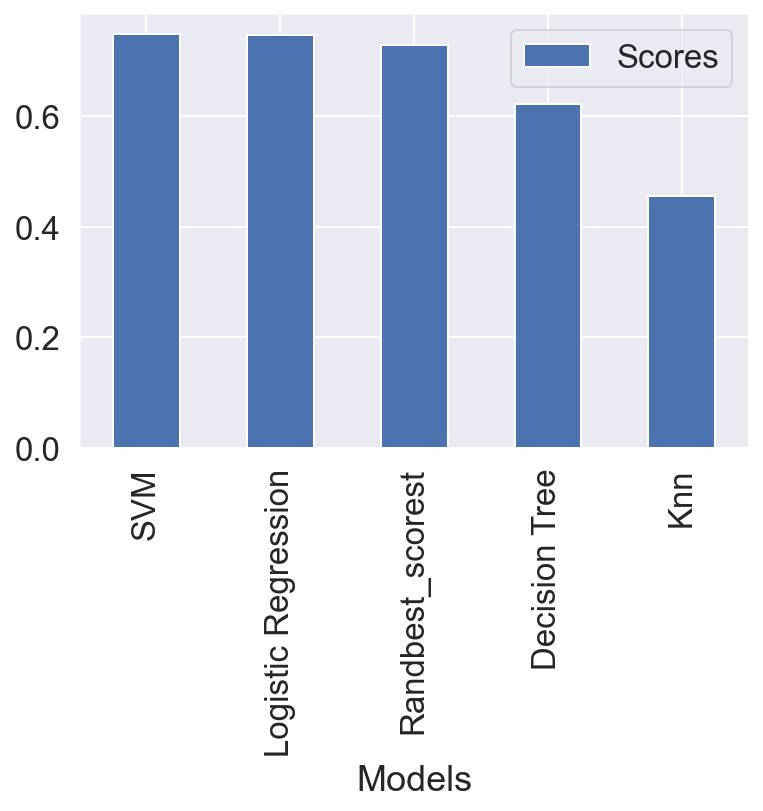

In [548]:
# Define dataframes has the all model with their test scores
best_score_df = pd.DataFrame({'Models':best_score.keys(),'Scores':best_score.values()})
best_score_df.sort_values('Scores',ascending=False).plot(kind='bar',x='Models',y='Scores');

The SVM has the best test score among all models.